In [1]:
import random
import numpy as np
from IPython.core.display import display, HTML
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import seaborn as sns
from matplotlib import pylab as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
# setup disply parameters
float_formatter = StrMethodFormatter('{x:0.03f}')
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6))  # set figure size
plt.rc("animation", html="html5")
pd.set_option('display.max_rows', 500)
np.random.seed(13034)
random.seed(13034)

In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint

## Developing an agent for SCML2024 (Standard)

In 2024, we introduced a new implementation of the SCML-Standard track which simplified its API making it exactly the same as the simpler SCML-OneShot track. The older version of the game is not supported anymore.

**SCML-Std brief introduction** Please refer to the first tutorial for a brief introduction about the world simulated in this game as well as pointers to more information. We will assume knowledge of at least this brief introduction in the remainder of this tutorial.

The main differences between the Standard and OneShot simulation that will affect this tutorial are the following:

1. Agents can negotiate **future contracts** instead of only being allowed to negotiate about deliveries on the same day. This means that we better consider future contracts when negotiating instead of trying to secure all of our needs on the day they arise.
2. Negotiated **prices have a larger range** which necessitates reasoning about prices as well as quantity matching. This means that we should be careful about accepting good prices (i.e. low prices when buying and high prices when selling).
3. Production graphs can be **deeper** which means that some agents will negotiate with **both** their suppliers and consumers at the same time. This means that our agent may find itself in the **middle** of the production graph with no exogenous contracts. In such cases, the agent may set some target production level and try to achieve it instead of relying on its exogenous contracts to set its targets.


Let's defines some helper functions that will be used throughout this tutorial to test our agents:

In [3]:
from collections import defaultdict
import random
from negmas import ResponseType, SAOResponse
from scml.std import *
from scml.std.world import DUMMY_AGENT_BEGINNING
from scml.std.common import is_system_agent
from rich import print
import math
from typing import Iterable

CONFIGS = dict()
DefaultType = GreedyStdAgent

def try_agent(agent_type, alone=False, **kwargs):
    """Runs an agent in a world simulation against a randomly behaving agent"""
    if alone:
        return try_agents([agent_type, agent_type],**kwargs)
    return try_agents([DefaultType, agent_type],**kwargs)

def make_configs(n, n_trials, n_processes, n_steps=10):
    types = [f"{DUMMY_AGENT_BEGINNING}{i}" for i in range(n)]
    return [(
        types, 
        SCML2024StdWorld.generate(types, agent_params=None, n_steps=10, 
        n_processes=n_processes, random_agent_types=True, construct_graphs=True)         
    ) for _ in range(n_trials)]

def try_agents(agent_types, n_processes=3, n_trials=4, n_steps=10, draw=True, agent_params=None, debug=True):
    """
    Runs a simulation with the given agent_types, and n_processes n_trial times.
    Optionally also draws a graph showing what happened
    """
    n = len(agent_types)
    if (n, n_processes) not in CONFIGS:
        CONFIGS[(n, n_processes)] =  make_configs(n, n_trials, n_processes, n_steps) 
    n_rem = n_trials - len(CONFIGS[(n, n_processes)])
    if n_rem > 0:
        CONFIGS[(n, n_processes)] += make_configs(n, (n_rem), n_processes, n_steps)
    configs = CONFIGS[(n, n_processes)]
    type_scores = defaultdict(float)
    counts = defaultdict(int)
    agent_scores = dict()
    worlds = []
    for old_types, config in configs[:n_trials]:
        p = n_processes if isinstance(n_processes, int) else random.randint(*n_processes)
        world = SCML2024StdWorld(
            **SCML2024StdWorld.replace_agents(config, old_types, agent_types, agent_params), debug=debug
        )
        worlds.append(world)
        world.run()

        all_scores = world.scores()
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            key = aid if n_trials == 1 else f"{aid}@{world.id[:4]}"
            agent_scores[key] = (
                 agent.type_name.split(':')[-1].split('.')[-1],
                 all_scores[aid],
                 '(bankrupt)' if world.is_bankrupt[aid] else ''
                )
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            type_ = agent.type_name.split(':')[-1].split('.')[-1]
            type_scores[type_] += all_scores[aid]
            counts[type_] += 1
    type_scores = {k: v/counts[k] if counts[k] else v for k, v in type_scores.items()}
    if draw:
        draw_worlds(worlds)
        

    return worlds, agent_scores, type_scores

def draw_worlds(worlds):
    n_trials = len(worlds)
    mx = min(n_trials, 2)
    fig = plt.figure(figsize=(11*mx, 8))
    axs = fig.subplots(int(math.ceil(n_trials / mx)), mx)
    if isinstance(axs, Iterable):
        axs = axs.flatten()
    for ax, world in zip(axs if n_trials > 1 else [axs], worlds):            
        world.draw(
            what=["contracts-concluded"],
            steps=(0, world.n_steps - 1),
            together=True, ncols=1,
            axs=ax
        )
    plt.show()

def plot_stats(worlds, types=None, exclude=(DefaultType,), separate_levels=True):
    
    n_steps = max(_.n_steps for _ in worlds)
    
    def init_stats():
        return dict(
            shortfall_quantity=[0] * n_steps, inventory_penalized=[0] * n_steps, 
            productivity=[0] * n_steps, shortfall_penalty=[0] * n_steps, storage_cost=[0] * n_steps
        )

    stats=init_stats()
    
    fig, axs = plt.subplots(1, len(stats))
    levels = list(range(5))
    if types is None:
        types = []
        for world in worlds:
            types += [type(_._obj) for _ in world.agents.values() if _ != None and _._obj != None]
        types = [_ for _ in set(types) if not any (_ == e for e in exclude)]
    for type_ in types:
        for level in ([None] if not separate_levels else levels):
            n_agents = 0
            stats = init_stats()
            for world in worlds:        
                for aid, agent in world.agents.items():
                    if not isinstance(agent._obj, type_):        
                        continue
                    if level is not None and world.agent_profiles[aid].level != level:
                        continue
                    n_agents += 1
                    for s in stats.keys():        
                        sname = f"{s}_{aid}"
                        if s.endswith("_input") or s.endswith("_output"):
                            sname=f"{s.split('_')[0]}_{aid}"+"_" + s.split("_")[-1]                    
                        v = world.stats[sname]                        
                        for t, x in enumerate(v):
                            stats[s][t] += x                        
            if n_agents == 0:
                continue
            for ax, (s, vals) in zip(axs, stats.items()):
                lbl=f"{type_.__name__}@{level}" if level is not None else type.__name__
                ax.plot([_/n_agents for _ in vals], label=lbl)
                ax.set_title(s)
            ax.legend()

def analyze_contracts(worlds):
    """
    Analyzes the contracts signed in the given world
    """
    import pandas as pd
    dfs = []
    for world in worlds:
        dfs.append(pd.DataFrame.from_records(world.saved_contracts))
    data = pd.concat(dfs)
    return data.groupby(["seller_name", "buyer_name"])[
        ["quantity", "unit_price"]
    ].agg(dict(quantity=("sum", "count"), unit_price="mean"))


def print_agent_scores(agent_scores):
    """
    Prints scores of individiual agent instances
    """
    for aid, (type_, score, bankrupt) in agent_scores.items():
        print(f"Agent {aid} of type {type_} has a final score of {score} {bankrupt}")

def print_type_scores(type_scores):
    """Prints scores of agent types"""
    print(sorted(tuple(type_scores.items()), key=lambda x: -x[1]))

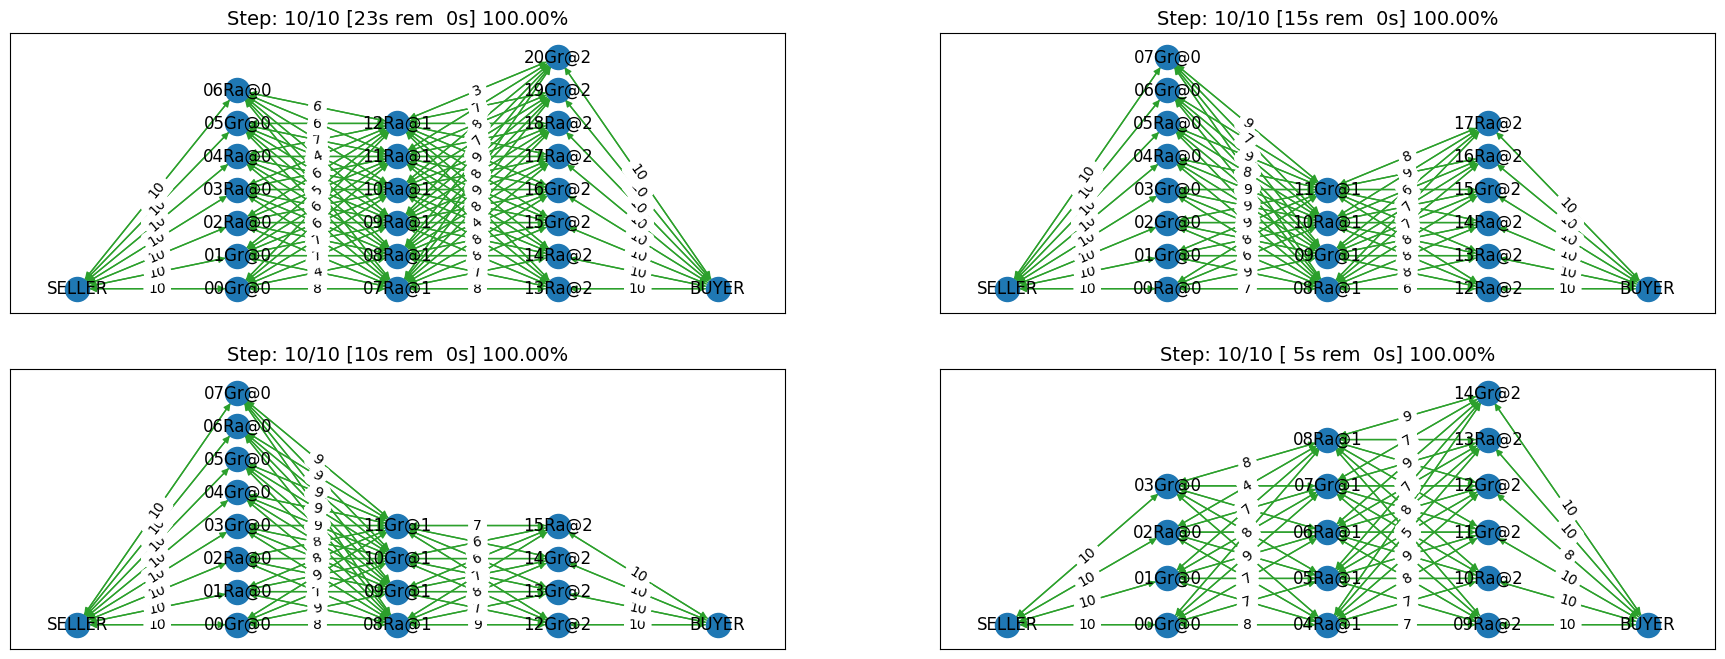

In [4]:
worlds, ascores, tscores = try_agent(RandomStdAgent)

In [5]:
print_type_scores(tscores)

[('GreedyStdAgent', 0.9767744888492305), ('RandomStdAgent', 0.31321256075792864)]

This score is much lower than what we got in the oneshot world. Some of the reasons for that are the following:

1. In the standard game, the range of prices is large enough that price matters. Choosing a random price is not a good idea here. In the oneshot game, on the other hand, price range was extremely small that the price did not really matter.
2. In the oneshot game, all negotiations happen about deliveries on the same day and products are perishable so you do not accomulate stock over time. In the standard game, on the other hand, negotiations are about deliveries on the same day or  the future. Picking randomly from those will reduce the probability of picking what you need today and increase the probability of picking something you do not really need in the future.

Now we are ready to develop a do-nothing agent:

In [6]:
class MyStdDoNothing(StdPolicy):
    """My Agent that does nothing"""
    def act(self, state):
        return { partner: SAOResponse(ResponseType.END_NEGOTIATION, None)
                for partner in state.my_suppliers + state.my_consumers}

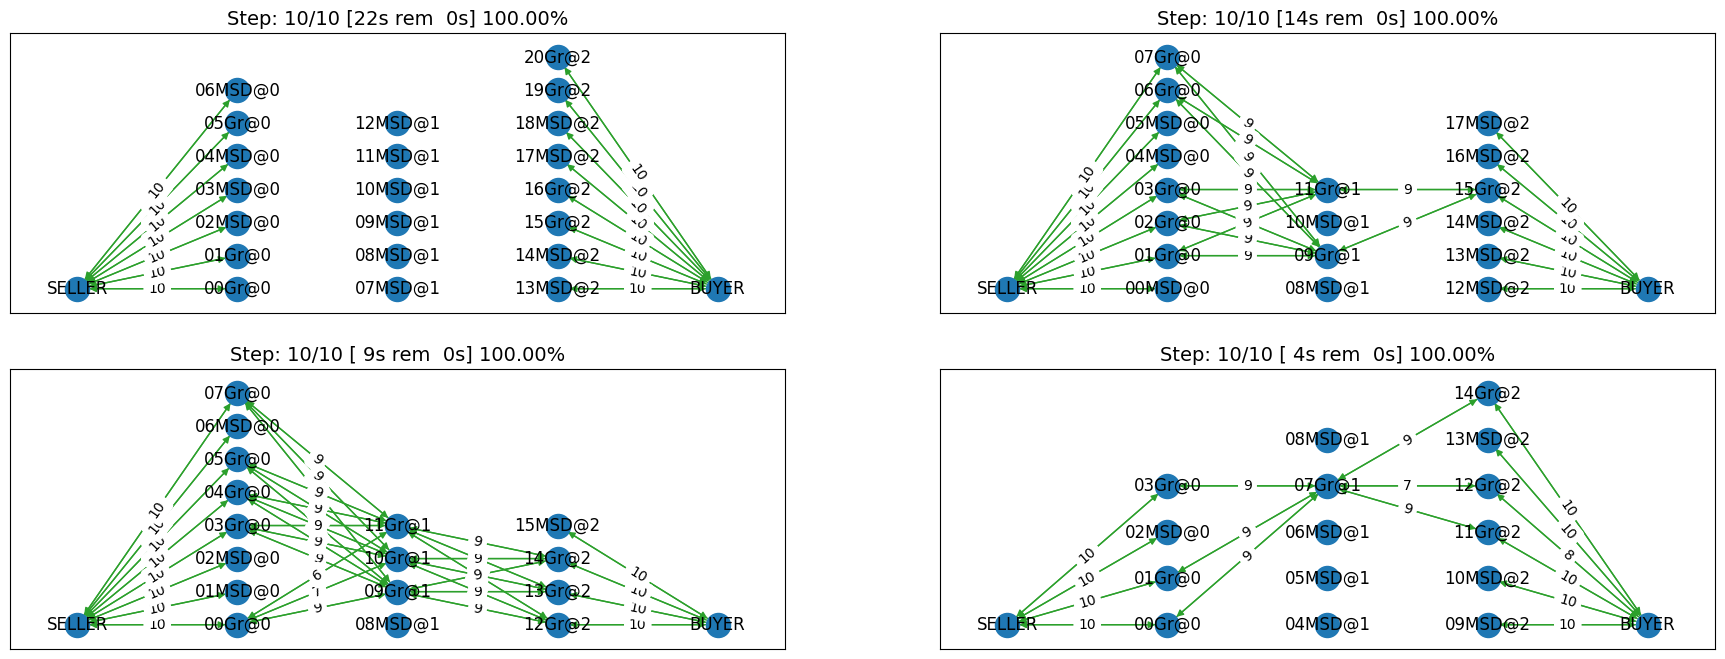

In [7]:
worlds, ascores, tscores = try_agent(MyStdDoNothing)

In all of the graph representing world simulations, we use short names that represent the type of the agent. For example an agent named `01Gr@0` is an agent of type `GreedyStdAgent` at production level 1 that was the third agent to create. `MSD` here is a shorthand for `MyStdDoNothingAgent`.

Looking at the `contracts-concluded`, we can see that none of the concluded contracts involved our do-nothing agent. Nevertheless, these agents still had *exogenous contracts* which means that they will lose money. A do-nothing agent will usually lose money in this game.

Let's check the scores of different agents to confirm:

In [8]:
print_agent_scores(ascores)

Agent 00Gr@0@SCML of type GreedyStdAgent has a final score of 0.7167256979010428

Agent 01Gr@0@SCML of type GreedyStdAgent has a final score of 0.7942563513261844

Agent 02MSD@0@SCML of type MyStdDoNothing has a final score of 0.6883593779018097

Agent 03MSD@0@SCML of type MyStdDoNothing has a final score of 0.6108966500189354

Agent 04MSD@0@SCML of type MyStdDoNothing has a final score of 0.5214749962363971

Agent 05Gr@0@SCML of type GreedyStdAgent has a final score of 0.8325289487562683

Agent 06MSD@0@SCML of type MyStdDoNothing has a final score of 0.6281778341193385

Agent 07MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 08MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 09MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 10MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 11MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 12MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 13MSD@2@SCML of type MyStdDoNothing has a final score of 0.5288547655544195

Agent 14MSD@2@SCML of type MyStdDoNothing has a final score of 0.8843767791486963

Agent 15Gr@2@SCML of type GreedyStdAgent has a final score of 1.1256074408660832

Agent 16Gr@2@SCML of type GreedyStdAgent has a final score of 0.7569446161026442

Agent 17MSD@2@SCML of type MyStdDoNothing has a final score of 0.685008670446745

Agent 18MSD@2@SCML of type MyStdDoNothing has a final score of 0.38571972238695607

Agent 19Gr@2@SCML of type GreedyStdAgent has a final score of 0.7741818802592972

Agent 20Gr@2@SCML of type GreedyStdAgent has a final score of 0.84708175597462

Agent 00MSD@0@SCML of type MyStdDoNothing has a final score of 0.8034431759177388

Agent 02Gr@0@SCML of type GreedyStdAgent has a final score of 1.0731594327175822

Agent 03Gr@0@SCML of type GreedyStdAgent has a final score of 0.7950666671190133

Agent 05MSD@0@SCML of type MyStdDoNothing has a final score of 0.4823298045531368

Agent 06Gr@0@SCML of type GreedyStdAgent has a final score of 0.9620021442594535

Agent 07Gr@0@SCML of type GreedyStdAgent has a final score of 0.7525348485607771

Agent 09Gr@1@SCML of type GreedyStdAgent has a final score of 0.8871028396829168

Agent 11Gr@1@SCML of type GreedyStdAgent has a final score of 0.8455313220292289

Agent 12MSD@2@SCML of type MyStdDoNothing has a final score of 0.8032007818787231

Agent 16MSD@2@SCML of type MyStdDoNothing has a final score of 0.8874599355768298

Agent 01MSD@0@SCML of type MyStdDoNothing has a final score of 0.7568459216717972

Agent 04Gr@0@SCML of type GreedyStdAgent has a final score of 0.8470782954089534

Agent 10Gr@1@SCML of type GreedyStdAgent has a final score of 0.8623714278680734

Agent 12Gr@2@SCML of type GreedyStdAgent has a final score of 1.0313185672562994

Agent 13Gr@2@SCML of type GreedyStdAgent has a final score of 1.036064445845995

Agent 14Gr@2@SCML of type GreedyStdAgent has a final score of 0.9700573313937086

Agent 15MSD@2@SCML of type MyStdDoNothing has a final score of 0.7630919746597828

Agent 04MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 05MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 06MSD@1@SCML of type MyStdDoNothing has a final score of 1.0

Agent 07Gr@1@SCML of type GreedyStdAgent has a final score of 0.8447383228336929

Agent 09MSD@2@SCML of type MyStdDoNothing has a final score of 0.7050783101620703

Agent 10MSD@2@SCML of type MyStdDoNothing has a final score of 0.5024602741981566

Agent 11Gr@2@SCML of type GreedyStdAgent has a final score of 1.0314029199938892

Notice that our do-nothing agent always loses money. That is because it cannot get any contracts from negotiation to satisfy its needs from the exogenous contracts but it still has to pay for disposal cost and shortfall penalty.

In [9]:
print_type_scores(tscores)

[('GreedyStdAgent', 0.8539959430373113), ('MyStdDoNothing', 0.7905699986837122)]

We can also have a look at the *exogenous* contracts that drive the market.

In [10]:
analyze_contracts((worlds[0],))

quantity       unit_price
                            sum count       mean
seller_name buyer_name                          
13MSD@2     BUYER            29    10       38.5
14MSD@2     BUYER            74    10       44.4
15Gr@2      BUYER            89    10       38.0
16Gr@2      BUYER            82    10       36.9
17MSD@2     BUYER            65    10       39.6
18MSD@2     BUYER            92    10       44.4
19Gr@2      BUYER            68    10       41.1
20Gr@2      BUYER            39    10       41.7
SELLER      00Gr@0           87    10       10.5
            01Gr@0           78    10       10.1
            02MSD@0          92    10        8.6
            03MSD@0          94    10        9.8
            04MSD@0          91    10        9.9
            05Gr@0           85    10        9.6
            06MSD@0          90    10        9.9

There are few things to note about the distribution of the *exogenous* contracts:

- The unit price of the raw material is always lower than that of the final product. This is the source of profitability in this market.
- Each agent has a different mean and standar deviation for the quantities in its exogenous contracts. This means that different agents will have different utility functions but these utility functions for different steps are related because the exogenous contract is sampled from some common distribution for each agent for all the steps which makes learning more useful in the game.

### Building your own agent

A standard agent needs only to do negotiation. The simplest possible version (`MyDoNothingAgent` above) just responded to offers from its partners and proposed new offers to them.

#### Your AWI

As described in a [previous tutorial](https://scml.readthedocs.io/en/latest/tutorials/01.run_scml2020.html), your agent can sense and act in the simulation by accessing methods and properties of its AWI which is accessible at any time as:

```python
self.awi
```

You can see all of these methods and properties specific for the **StdAWI** and its descendents [here](https://scml.readthedocs.io/en/latest/api/scml.std.StdAWI.html).

#### Your ufun

The Std game has the advantage that it is possible at the end of each simulation step (day) to calculate **exactly** the profit you will be getting for the set of contracts you have (either through negotiation or as exogenous contracts). We provide a utility function class ([StdUtilityFunction](https://scml.readthedocs.io/en/latest/api/scml.std.StdUFun.html) which can be used normally as any NegMAS [UtilityFunction](http://www.yasserm.com/negmas/api/negmas.preferences.UtilityFunction.html). This ufun is available to your all the time (a new one is created for each simulation step) and is accessible as:

```python
self.ufun
```

The most important services this ufun class provides for you are the following:

- `from_offers`: This method receives a list of outcomes and a list of booleans indicating whether each of them is for buying or for selling. It returns to you the profit you will get if all of these outcomes _and nothing else_ became contracts. An outcome is just a tuple (quantity, delivery time, unit price). You can use this callback during negotiation to judge hypothetical agreements with your partners. **Note that only offers to be delivered today will be considered**
- `from_contracts`: This method is the same as `from_offers` but it receives a list of `Contract` objects. It is useful after all negotiations are finished to calculate the profit you will be getting for this step. **Note that only contracts to be delivered today will be considered**
- `is_breach`: will tell you whether or not getting the given total input and output quantities will make you cause a breach. Notice that breaches are expected in the Standard track as any mismatch in the quantities of inputs and outputs will constitute a breach.
- `breach_level`: returns a value between zero and one specifying the level of breach that will be recorded for a given total input and output quantities.
- `find_limit`: finds either the maximum or the minimum possible profit (minimum profit is maximum loss) attainable in the current simulation step (day). This is useful when you want to normalize utility values between zero and one. Two of the agents we will develop during this tutorial will use this feature.
- `max_utility`, `min_utility`: give the maximum and minimum utilities/profits attainable. Note that you must prepare them by calling `find_limit`. We will go into how to do that later.
- `best`, `worst`: give more information about the cases of maximum and minimum profit (i.e. the total input and output quantity needed, the prodcible quantity, best possible prices for buying and selling, etc). Again, these are not available except after calling `find_limit`.

#### Your callbacks

Your agent needs to implement methods that are called by the system at various time during the negotiation. You can find a full list in the [game description](https://yasserfarouk.github.io/files/scml/y2024/scml2024.pdf).

The most important ones are:

- `init()` called once at the beginning of the simulation (i.e. before the first day starts). At this point, your AWI is set but you should not assume anything else.
- `before_step()` called at the **beginning** of _every day_. At this point, your `ufun` is set and market information is available.
- `step()` called at the **end** of _every day_. You can use this to analyze what happened during the day and modify your strategy in the future.
- `on_negotiation_success()`/`on_negotiation_failure()` called after each negotiation is concluded to let you know what happened in it.
- Depending on your base-class, you will also need to implement methods that allow you to control negotiations. These will be explained in details in the following sections but here is a summary:
  - **StdAgent** If your agent is based on `StdAgent`, you will get a `propose()` call when you need to offer something to one of our partners during negotiation and `respond()` when asked to respond to one of its offers.
  - **StdSyncAgent** If your agent is based on `StdSyncAgent` you will get a call to `first_proposals()` once every day to set your first proposal in all negotiations and a `counter_all()` call to counter offers from your partners. The system will try to always give you one offer from each partner in the `counter_all()` call but that is not guaranteed and sometimes it may be called with a subset of the offers.

Now we can start working on our agent.

There are two base classes for standard agents (`StdAgent`, and `SyncStdAgent`). We will discuss them in more details in what follows.

### StdAgent

This is the base class of all agents for SCML-Std.  `SyncStdAgent` inherit from this class and provide support for a simplified way of developing your agent (or so we think). It is perfectly OK to use `StdAgent` directly as the base of your agent.

We have already seen the `StdAgent` class for which you need to override `propose` and may also override `respond` to handle negotiations independently. The `propose` method receives the negotiation state (an object of the type `SAOState` including among other things the current negotiation step, relative time, last offer, etc) and is required to return an `Outcome` (See `negmas` documentation) as an offer. The `respond` method receives a negotiation state and an offer (`Outcome`) from the opponent and needs to respond to it by a decision from the `ResponseType` enumeration (`REJECT_OFFER`, `ACCEPT_OFFER`, and `END_NEGOTIATION`). Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `propose` are optional.

#### Simple StdAgent

We have already seen how to develop a do-nothing agent using the `StdAgent` class. Let's try to develop some more meaningful agent using the same base class.


In [40]:
class SimpleAgent(StdAgent):
    """A greedy agent based on StdAgent"""        

    def __init__(
        self, *args, production_level=0.25, future_concession=0.1, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.production_level = production_level
        self.future_concession = future_concession
    
    def init(self):
        profile  = self.awi.profile
        if profile.shortfall_penalty_mean:
            self.ratio = min(1.0, max(0.0, 
                profile.storage_cost_mean / profile.shortfall_penalty_mean
            ))
        else:
            self.ratio = 1.0

    def propose(self, negotiator_id: str, state):
        return self.good_offer(negotiator_id, state)
        

    def respond(self, negotiator_id, state, source=''):
        # accept any quantity needed at a good price
        offer = state.current_offer        
        return (
            ResponseType.ACCEPT_OFFER
            if self.is_needed(negotiator_id, offer) 
            and self.is_good_price(negotiator_id, offer, state)
            else ResponseType.REJECT_OFFER
        )

    def is_needed(self, partner, offer):
        if offer is None:
            return False
        return offer[QUANTITY] <= self._needs(partner, offer[TIME])
    
    def is_good_price(self, partner, offer, state):
        if offer is None:
            return False
        nmi = self.get_nmi(partner)
        if not nmi:
            return ResponseType.END_NEGOTIATION
        issues = nmi.issues
        minp = issues[UNIT_PRICE].min_value
        maxp = issues[UNIT_PRICE].max_value
        r = state.relative_time
        if offer[TIME] > self.awi.current_step:
            r *= self.future_concession
        if self.is_consumer(partner):
            return offer[UNIT_PRICE] >= minp + (1-r) * (maxp-minp)
        return -offer[UNIT_PRICE] >= -minp + (1-r) * (minp-maxp)

    def good_offer(self, partner, state):
        nmi = self.get_nmi(partner)
        if not nmi:
            return None
        issues = nmi.issues
        qissue = issues[QUANTITY]
        pissue = issues[UNIT_PRICE]
        for t in sorted(list(issues[TIME].all)):
            needed = self._needs(partner, t)
            if needed <= 0:
                continue            
            offer = [-1] * 3
            offer[QUANTITY] = max(
                min(needed, qissue.max_value), qissue.min_value
            )
            offer[TIME] = t
            r = state.relative_time
            if t > self.awi.current_step:
                r *= self.future_concession
            minp, maxp = pissue.min_value, pissue.max_value
            if self.is_consumer(partner):
                offer[UNIT_PRICE] = int(minp + (maxp - minp) * (1-r) + 0.5)
            else:
                offer[UNIT_PRICE] = int(minp + (maxp-minp) * r +0.5)
            return tuple(offer)
        return None

    
    def is_consumer(self, partner):
        return partner in self.awi.my_consumers

    def _needs(self, partner, t):
        # find my needs today
        if self.awi.is_first_level:
            total_needs = self.awi.needed_sales
        elif self.awi.is_last_level:
            total_needs = self.awi.needed_supplies
        else:
            total_needs = self.production_level * self.awi.n_lines
        print(f"{self.id} ({self.awi.current_step}): Exogenous: {self.awi.current_exogenous_input_quantity if self.is_first_level else (self.awi.current_exogenous_output_quantity if self.is_last_level else 0)}\t Today: {total_needs}\t", end="")
        # estimate future needs
        if self.is_consumer(partner):
            total_needs += (
                self.production_level * self.awi.n_lines * (t - self.awi.current_step)
            )
            print(f"{self.id} ({self.awi.current_step}): Future: {total_needs}\t", end="")            
            total_needs -= self.awi.total_sales_until(t)                     
            print(f"{self.id} ({self.awi.current_step}): Needed: {total_needs}")
        else:            
            total_needs += (
                self.production_level * self.awi.n_lines * (self.awi.n_steps - t - 1) * (1-self.ratio)
            )
            print(f"{self.id} ({self.awi.current_step}): Future: {total_needs}\t", end="")            
            total_needs -= self.awi.total_supplies_between(t, self.awi.n_steps - 1) 
            print(f"{self.id} ({self.awi.current_step}): Needed: {total_needs}")
        # subtract already signed contracts
        return int(total_needs)



In [ ]:
worlds, ascores, tscores = try_agent(SimpleAgent, alone=True)

Let's see how well did this agent behave:

In [38]:
print_type_scores(tscores)

[('SimpleAgent', 0.8225608788747852)]

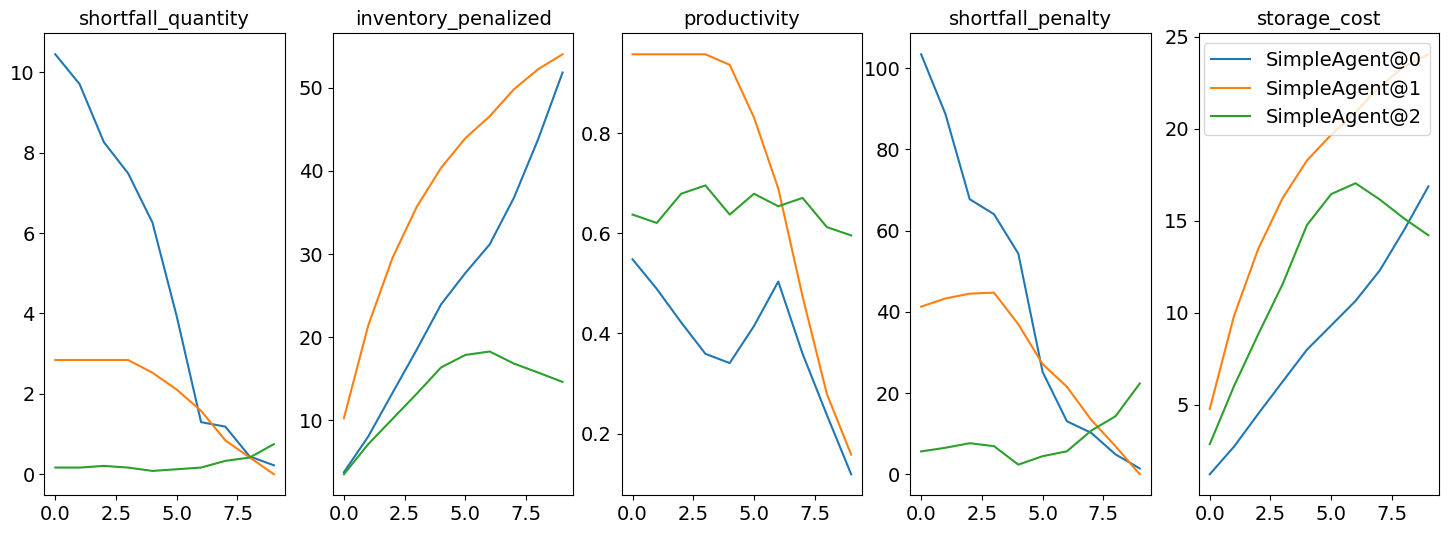

In [39]:
plot_stats(worlds)

This simple agent is better than the random agent. Let's understand how it works:

The main idea of this agent is pretty simple. It tries to *secure* as much of its needs (sales/supplies) as possible in every negotiation at the best possible price for itself.

To achieve this goal, the agent uses the fact that the `AWI` already keeps track of this information as `needed_supplies` and `needed_sales`.
Therefore, it defines a helper that calculates the amount it needs by subtracting the exogenous quantity it has from the amount it secured

```python
def _needed(self):
    if self.awi.is_middle_level:
            return self.awi.n_lines
    self.awi.needed_sales if self.is_seller(negotiator_id) else self.awi.needed_supplies
```

where it uses `needed_sales` if the current negotiation is for selling and `needed_supplies` otherwise. Now that the agent can calculate how much it needs to buy/sell, it implements the negotiation related call-backs (`propose` and `respond`). 

Here is the full implementation of `propose`:
```python
def propose(self, negotiator_id: str, state) -> "Outcome":
        return self.best_offer(negotiator_id)
```

The agent is always offering its best offer which is calculated in the `best_offer` method to be discussed later. It does not conceed at all.

Responding to opponent offers is also simple:

- it starts by calculating its needs using the helper `_needed`, and ends the negotiation if it needs no more sales/supplies
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return ResponseType.END_NEGOTIATION
```
- If the offered quantity is less than its needs, accept the offer. Otherwise reject the offer.
```python
    return ResponseType.ACCEPT_OFFER if offer[QUANTITY] <= my_needs else ResponseType.REJECT_OFFER
```

Most of the code is in the `best_offer` method which calculates the best offer for a negotiation *given the agreements reached so far*. Let's check it line by line:

- The agent checks its needs and returns `None` ending the negotiation if it needs no more sales/supplies. We also get access to the AMI.
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return None
    ami = self.get_nmi(negotiator_id)
    if not ami:
        return None
```

- It then finds out the `Issue` objects corresponding to the quantity and unit-price for this negotiation and initializes an offer (we have 3 issues)
```python
    quantity_issue = ami.issues[QUANTITY]
    unit_price_issue = ami.issues[UNIT_PRICE]
    offer = [-1] * 3
```
- The time is always the current step. 
```python    
    offer[TIME] = self.awi.current_step
```
- The quantity to offer is simply the needs of the agent without mapped within the range of the quantities in the negotiation agenda (note that this may lead the agent to buy more than its needs). 
```python    
    offer[QUANTITY] = max(
        min(my_needs, quantity_issue.max_value), quantity_issue.min_value
    )
```
- Finally, the unit price is the maximum possible unit price if the agent is selling otherwise it is the minimum possible price. Note that `is_selling()` assumes that the agent will never find itself in a middle layer in a deep negotiation. We will alleviate this issue later. 
```python
    if self._is_selling(ami):
        offer[UNIT_PRICE] = unit_price_issue.max_value
    else:
        offer[UNIT_PRICE] = unit_price_issue.min_value
    return tuple(offer)
```

### A (suposedly) better greedy agent

One problem with our `SimpleAgent` is that it does not take price into account in two ways:

- When asked to `propose`, it *always* proposes an offer with the best price for itself. It **never concedes** on prices. In many cases this will lead to disagreement.
- When asked to `respond` to an offer, *it does not even check the price*. This may lead to bad agreements (i.e. very high buying prices/very low selling prices).

We will try to remedie both of these issues in the following agent:

In [15]:
class BetterAgent(SimpleAgent):
    """A greedy agent based on OneShotAgent with more sane strategy"""

    def propose(self, negotiator_id, state):
        offer = self.good_offer(negotiator_id, state)
        if offer is None:
            return offer
        offered = self._offered(negotiator_id)
        offered[negotiator_id] = {offer[TIME]: offer[QUANTITY]}
        return offer

    def before_step(self):
        self.offered_sales = defaultdict(lambda: defaultdict(int))
        self.offered_supplies = defaultdict(lambda: defaultdict(int))

    def on_negotiation_success(self, contract, mechanism):
        partner = [_ for _ in contract.partners if _ != self.id][0]
        offered = self._offered(partner)
        offered[partner] = dict()

    def _offered(self, partner):
        if self.is_consumer(partner):
            return self.offered_sales
        return self.offered_supplies

    def _needs(self, partner, t):
        n = super()._needs(partner, t)
        offered = self._offered(partner)
        for k, v in offered[partner].items():
            if k > t:
                continue
            n = max(0, n - v)
        return int(n)

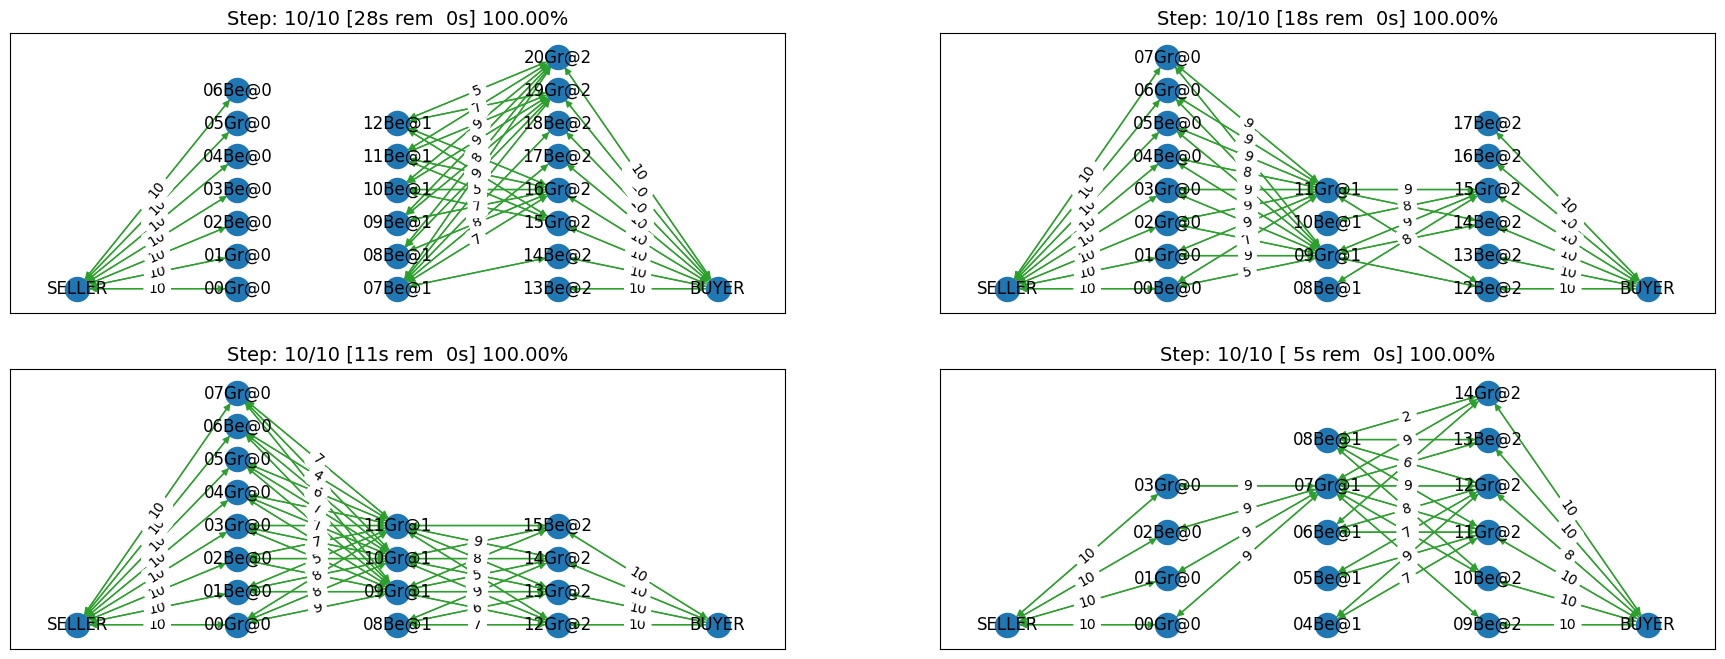

In [16]:
worlds, ascores, tscores = try_agent(BetterAgent)

Let's see how well did this agent behave:

In [17]:
print_type_scores(tscores)

[('GreedyStdAgent', 0.8537484055720409), ('BetterAgent', 0.843743172586257)]

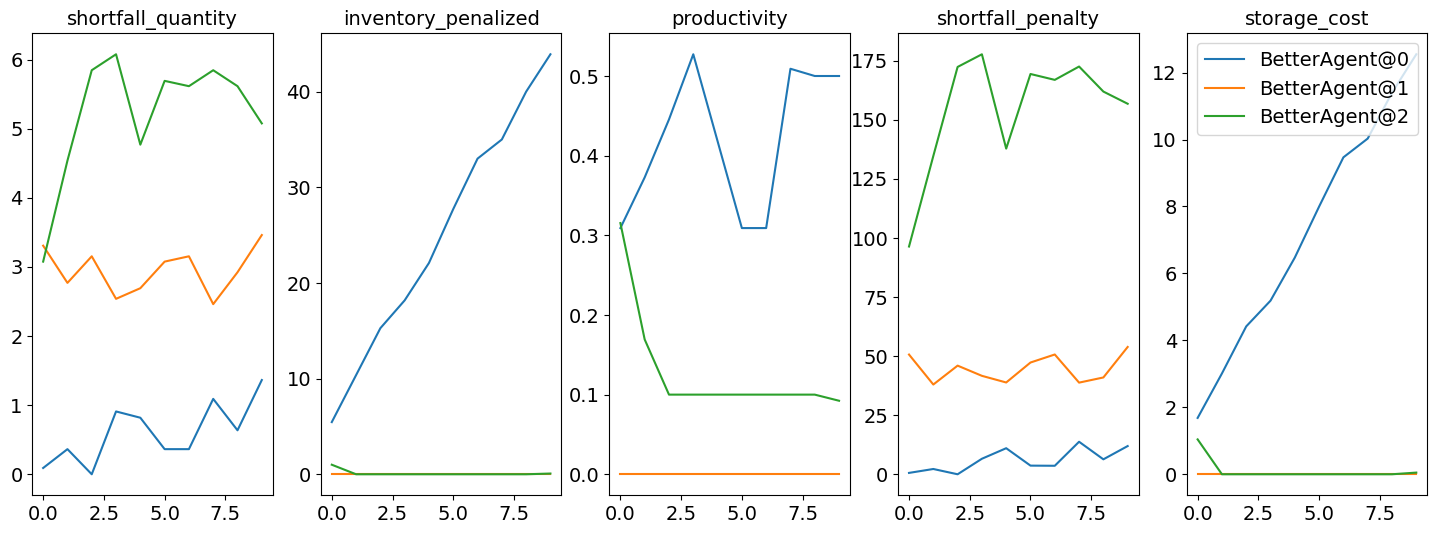

In [18]:
plot_stats(worlds)

It seems that `BetterAgent` is getting a score that is not any better than `SimpleAgent`. Let's dive into the agent and analyze how it works:

The main idea in `BetterAgent` is to treat the *price* issue separately to avoid the two issues presented earlier:

- **Never conceding during proposal** This is solved in the `propose` method by just overriding the price with a `good-enough` price:
  ```python
    offer[UNIT_PRICE] = self._find_good_price(
            self.get_nmi(negotiator_id), state
        )        
  ```
  As an aside, notice that we needed to convert the offer to a list in order to overwrite the price then back into a tuple to send it to the partner.
- **Never checking prices of offers** This is solved in the `respond` method by checking whether or not the price offered is a `good-enough` price:
  ```python
    return (
            response if
            self._is_good_price(ami, state, offer[UNIT_PRICE])
            else ResponseType.REJECT_OFFER
        )
  ```


What we mean by a `good-enough` price is defined in `_is_good_price` and `_find_good_price` methods. Both start by getting the limits of the unit-price in the negotiation agenda and a threshold value ```th```:

```python
mn, mx = self._price_range(ami, state)
th = self._th(mn, mx, state.step, ami.n_steps)
```

The price range is clear enough. For the threshold ```th``` is a value that starts at $1.0$ and goes down toward $0.0$ over the negotiation time under the control of an agent specific parameter ```_e``` called the concession exponent.
Let's see how does this look for different concession exponents:

### StdSyncAgent

One problem that plagued all of our agents so far is that they have to make decisions (`respond`, `propose`) about negotiations **on the spot**. This makes it difficult to consider **all other negotiations** while making decisions. 

Because the utility function is defined for **a complete set of negotiation agreements** and not for any single negotiation by itself, it makes sense to try to make decisions **centrally** by collecting offers from partners then responding to all of them at once. It is possible to do that by utilizing the response type ```ResponseType.WAIT``` supported by NegMAS but this entails a lot of house-keeping. 

To simplify this task, we provide another base class for agents that does all of this house keeping for you exposing a simple interface that **syncrhonizes** all negotiations (as much as allowed by the underlying platform). The main goal of this base agent is to allow the developer to think about *all negotiations together* but it has some important caveats which we will discuss later.
Here is an example of writing the do-nothing agent in this form:

In [19]:
from negmas import SAOResponse
class MySyncOneShotDoNothing(StdSyncAgent):
    """My Agent that does nothing"""
    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""
        return dict()
    
    def first_proposals(self):
        """Decide a first proposal on every negotiation. 
        Returning None for a negotiation means ending it."""
        return dict()
    

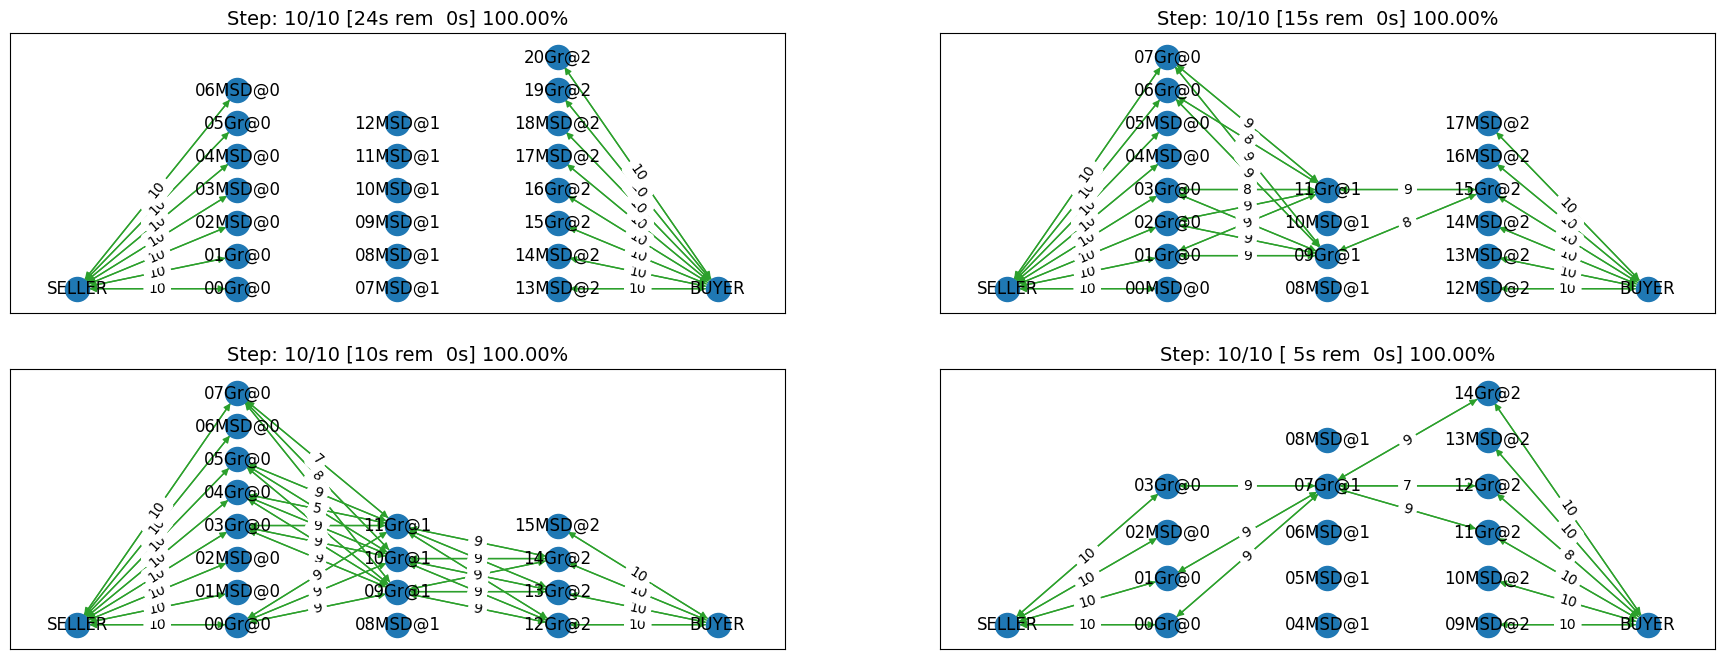

In [20]:
worlds, ascores, tscores = try_agent(MySyncOneShotDoNothing)

In [21]:
print_type_scores(tscores)

[('GreedyStdAgent', 0.8574644302042058), ('MySyncOneShotDoNothing', 0.7919293866514571)]

As you can see, in this case, we need to override `counter_all` to counter offers received from *all* the partners and `first_proposals` to decide a first offer for *each* partner. 

Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `counter_all` and `first_proposals` are optional.

In [22]:
class SimpleSyncAgent(StdSyncAgent, BetterAgent):
    """An agent that distributes its needs over its partners randomly."""

    def first_proposals(self):
        """Decide a first proposal on every negotiation.
        Returning None for a negotiation means ending it."""
        return {
            partner:
            SAOResponse(
                ResponseType.REJECT_OFFER,
                BetterAgent.propose(self, partner, state)
            )
            for partner, state in self.awi.current_states.items()
        }

    def counter_all(self, offers, states) -> dict:
        """Respond to a set of offers given the negotiation state of each."""
        # find all responses
        responses = {
            k: BetterAgent.respond(self, k, s) for k, s in states.items()
        }
        # find counter offers for rejected offers
        myoffers = {
            k: BetterAgent.propose(self, k, s) for k, s in states.items()
            if responses[k] == ResponseType.REJECT_OFFER
        }
        # compile final responses
        return {
            k:
            SAOResponse(
                responses[k],
                myoffers.get(
                    k, offers[k]
                    if responses[k] == ResponseType.ACCEPT_OFFER
                    else None
                )
            )
            for k in states.keys()
        }

    def propose(self, negotiator_id, state):
        return StdSyncAgent.propose(self, negotiator_id, state)

    def respond(self, negotiator_id, state, source=""):
        return StdSyncAgent.respond(self, negotiator_id, state, source)

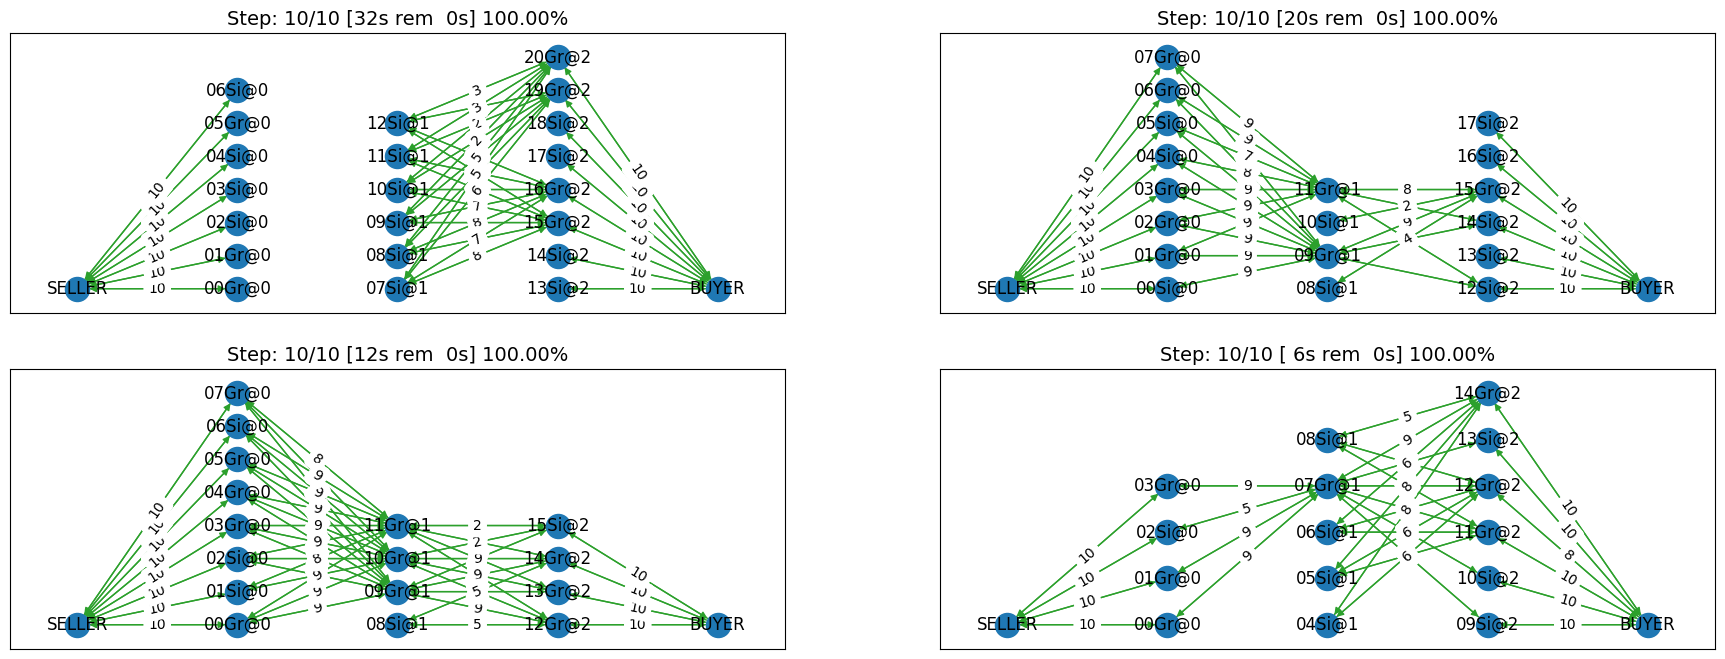

In [23]:
worlds, ascores, tscores = try_agent(SimpleSyncAgent)    

In [24]:
print_type_scores(tscores)

[('GreedyStdAgent', 0.8764978310835932), ('SimpleSyncAgent', 0.8443420693445334)]

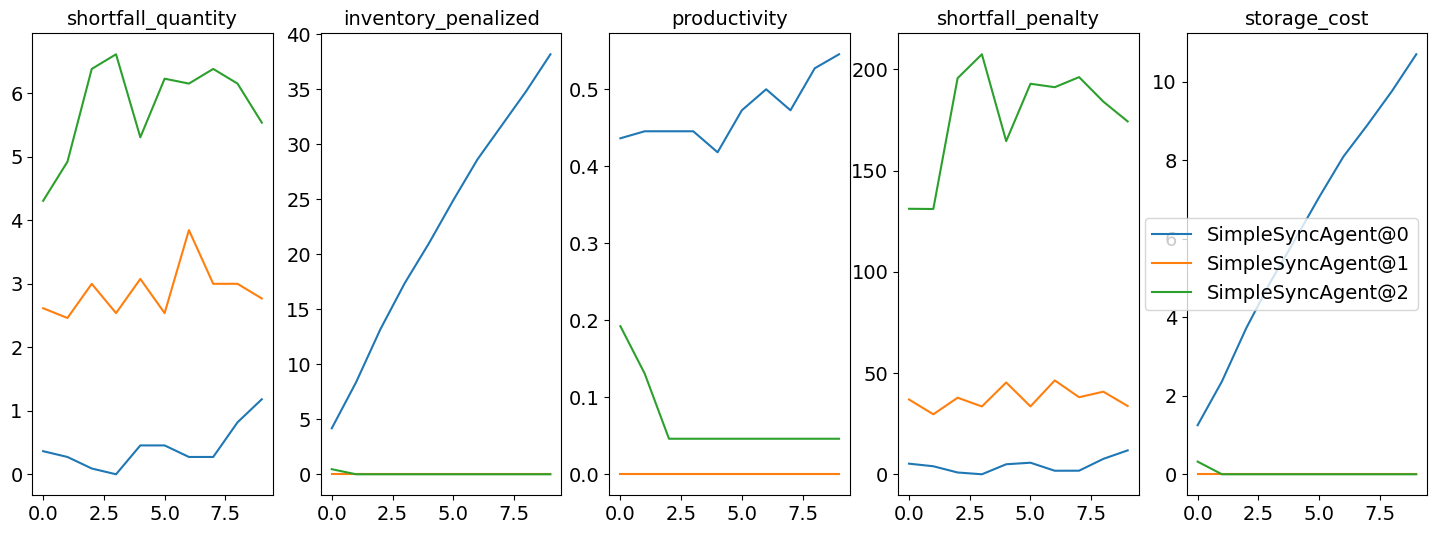

In [25]:
plot_stats(worlds)

This agent behaves exactly the same as `BetterAgent`. We simply just call `propose()` and `respond()` from `BetterAgent` **independently** for each negotiator and do not really use the fact that we have access to all the offers and can respond to all of them centrally now.

### A better SyncAgent

We start by defining a simple helper function that distributes a given quantity $q$ over $n$ partners.

In [26]:
def distribute(q: int, n: int) -> list[int]:
    """Distributes n values over m bins with at least one item per bin assuming q > n"""
    from numpy.random import choice
    from collections import Counter
    if q < n:
        lst = [0] * (n - q) + [1] * q
        random.shuffle(lst)
        return lst
        
    if q == n:
        return [1] * n
    r = Counter(choice(n, q - n))    
    return [r.get(_, 0) + 1 for _ in range(n)]

Here are few examples of how it would distribute $10$ units over $4$ partners

In [27]:
[distribute(10, 4) for _ in range(5)]

[[3, 3, 1, 3], [2, 1, 3, 4], [3, 3, 2, 2], [4, 1, 2, 3], [1, 2, 4, 3]]

In [28]:
[distribute(2, 4) for _ in range(5)]

[[0, 1, 0, 1], [1, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 1], [1, 1, 0, 0]]

We will also need a helper function to find all subsets of a given set (powerset):

In [29]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [30]:
class BetterSyncAgent(SimpleSyncAgent):
    def __init__(
        self, *args, threshold=None, **kwargs
    ):
        super().__init__(*args, **kwargs)
        if threshold is None:
            threshold = random.random() * 0.2 + 0.2
        self._threshold = threshold

    def __init__(self, *args, threshold=0.95, **kwargs):
        super().__init__(*args, **kwargs)
        self._threshold = threshold

    def distribute_todays_needs(self, partners=None) -> dict[str, int]:
        """Distributes my needs randomly over all my partners"""
        if partners is None:
            partners = self.negotiators.keys()

        response = dict(zip(partners, itertools.repeat(0)))
        for is_partner, edge_needs in (
            (self.is_supplier, self.awi.needed_supplies),
            (self.is_consumer, self.awi.needed_sales),
        ):
            needs = self.awi.n_lines if self.awi.is_middle_level else edge_needs
            # find my partners and the quantity I need
            active_partners = [_ for _ in partners if is_partner(_)]
            if not active_partners or needs < 1:
                continue
            random.shuffle(active_partners)
            active_partners = active_partners[
                : max(1, int(self._ptoday * len(active_partners)))
            ]
            n_partners = len(active_partners)

            # if I need nothing, end all negotiations
            if needs <= 0 or n_partners <= 0:
                continue

            # If my needs are small, use a subset of negotiators
            if needs < n_partners:
                active_partners = random.sample(
                    active_partners, random.randint(1, needs)
                )
                n_partners = len(active_partners)

            # distribute my needs over my (remaining) partners.
            response |= dict(
                zip(active_partners, distribute(needs, n_partners)))

        return response

    def sample_future_offer(self, partner_id):
        nmi = self.get_nmi(partner_id)
        outcome = nmi.random_outcome()
        if outcome[TIME] == self.awi.current_step:
            outcome = list(outcome)
            tissue = nmi.issues[TIME]
            if tissue.cardinality == 1:
                return None
            outcome[TIME] = random.randint(
                self.awi.current_step + 1, tissue.max_value)
            return tuple(outcome)
        return outcome

    def is_supplier(self, negotiator_id):
        return negotiator_id in self.awi.my_suppliers

    def first_proposals(self):
        # just randomly distribute my needs over my partners (with best price for me).
        s, p = self._step_and_price(best_price=True)
        distribution = self.distribute_needs()
        d = {k: (q, s, p) if q > 0 else None for k, q in distribution.items()}
        return d

    def counter_all(self, offers, states):
        response = dict()
        # process for sales and supplies independently
        for needs, all_partners, issues in [
            (
                self.awi.needed_supplies,
                self.awi.my_suppliers,
                self.awi.current_input_issues,
            ),
            (
                self.awi.needed_sales,
                self.awi.my_consumers,
                self.awi.current_output_issues,
            ),
        ]:
            # get a random price
            price = issues[UNIT_PRICE].rand()
            # find active partners
            partners = {_ for _ in all_partners if _ in offers.keys()}

            # find the set of partners that gave me the best offer set
            # (i.e. total quantity nearest to my needs)
            plist = list(powerset(partners))
            best_diff, best_indx = float("inf"), -1
            for i, partner_ids in enumerate(plist):
                others = partners.difference(partner_ids)
                offered = sum(offers[p][QUANTITY] for p in partner_ids)
                diff = abs(offered - needs)
                if diff < best_diff:
                    best_diff, best_indx = diff, i
                if diff == 0:
                    break

            # If the best combination of offers is good enough, accept them and end all
            # other negotiations
            if best_diff <= self._threshold:
                partner_ids = plist[best_indx]
                others = list(partners.difference(partner_ids))
                response.update(
                    {
                        k: SAOResponse(ResponseType.ACCEPT_OFFER, offers[k])
                        for k in partner_ids
                    }
                    | {
                        k: SAOResponse(ResponseType.END_NEGOTIATION, None)
                        for k in others
                    }
                )
                continue

            # If I still do not have a good enough offer, distribute my current needs
            # randomly over my partners.
            distribution = self.distribute_needs()
            response.update(
                {
                    k: SAOResponse(ResponseType.END_NEGOTIATION, None)
                    if q == 0
                    else SAOResponse(
                        ResponseType.REJECT_OFFER, (q,
                                                    self.awi.current_step, price)
                    )
                    for k, q in distribution.items()
                }
            )
        return response

NameError: name 'Outcome' is not defined

In [ ]:
worlds, ascores, tscores = try_agent(BetterSyncAgent)    

In [ ]:
print_type_scores(tscores)

In [ ]:
print_type_scores(tscores)

This is the highest score we got so far even though that agent is not that intelligent in its decision making. Let's check it in details:

The main idea is to generate offers that will (assuming all accepted) give us all the quantity we need (to buy/sell). Moreover, we accept a set of offers if the total quantity they provide is within some small margin from the quantity we need.


We have a helper method to calculate the quantity we need at any time which simply subtracts the secured quantity from our total exogenous contract quantities:

```python
def _needs(self):
    if self.awi.is_first_level:
        return self.awi.needed_sales
    return self.awi.needed_supplies
``` 

Another helper function (`_step_and_price`) is defined to return the current step and one of the two prices in the agenda:

```python
def _step_and_price(self, best_price = False):
    """Returns current step and a random (or max) price"""
    s = self.awi.current_step
    seller = self.awi.is_first_level
    issues = (
        self.awi.current_output_issues 
        if seller else 
        self.awi.current_input_issues
    )
    pmin = issues[UNIT_PRICE].min_value
    pmax = issues[UNIT_PRICE].max_value
    if best_price:
        return s, pmax
    return s, random.randint(pmin, pmax)
```

The core computation of the agent is implemented in the `distribute_needs()` method which is responsible of calculating a quantity for each partner (notice that price is completely ignored here).

Firstly, we find our partner and our needs and if we do not need anything, we simply return $0$ for all partners:

```python
  partner_ids = list(self.negotiators.keys())
  partners = len(partner_ids)
  needs = self._needs()
  if needs <= 0:
      return dict(zip(partner_ids, [0] * partners))
```

If our needs cannot be distributed over all partners, we select some of our partners randomly and return $0$ for them (as we will see, this will end the negotiation with these partners):

```python
if needs < partners:
    to_end = random.sample(partner_ids, (partners - needs))
    response = dict(zip(to_end, [0] * len(to_end)))
    partner_ids = [_ for _ in partner_ids if _ not in to_end]
    partners = len(partner_ids)
```

Finally, we simply distribute our needs over the remaining partners uniformly:

```python
response.update(dict(zip(partner_ids, distribute(needs, partners))))
```

Now we can move the main part of the agent which consists of the two abstract method implementations (`first_proposals` and `counter_all`).

#### First set of offers

The first set of proposals from the agent use the best price and will distribute the total quantity needed randomly between all partners:
```python
s, p = self._step_and_price(best_price=True)
distribution = self.distribute_needs()    
```

We then just return the quantity for each partner or `None` to end the negotiation if the quantity was $0$
```python
return dict((k, (q, s, p) if q > 0 else None)  for k, q in distribution.items())
```

#### Countering offers
When we receive some offers (in `counter_all`) we start by finding the subset of them (together) that best satisfy our needs up to a predefined threshold (defaulting to zero)

```python
plist = list(powerset(partners))
best_diff, best_indx = float("inf"), -1
for i, partner_ids in enumerate(plist):
    others = partners.difference(partner_ids)
    offered = sum(offers[p][QUANTITY] for p in partner_ids)
    diff = abs(offered - needs)
    if diff < best_diff:
        best_diff, best_indx = diff, i
    if diff == 0:
        break
```

If the best subset satisfies our needs up to a threshold (set as zero by default), we simply accept all of them ending all other negotiations:

```python
if best_diff <= self._threshold:
    partner_ids = plist[best_indx]
    others = list(partners.difference(partner_ids))
    return {
        k: SAOResponse(ResponseType.ACCEPT_OFFER, None) for k in partner_ids
    } | {k: SAOResponse(ResponseType.END_NEGOTIATION, None) for k in others}
```

*Note that we could slightly improve that by only rejecting the remaining offers and offering whatever we still need to buy/sell to them when the threshold is nonezero and the best subset has a total quantity less than our needs. This may improve our results slightly but will complicate the code so we do not pursue it in this tutorial.*

If the best subset does not satisfy our needs up to the predefined threshold, we simply ignore all offers and generate a new random offer for our partners:

```python
distribution = self.distribute_needs()
return {
    k: SAOResponse(ResponseType.END_NEGOTIATION, None)
    if q == 0
    else SAOResponse(ResponseType.REJECT_OFFER, (q, s, p))
    for k, q in distribution.items()
}
```    

*Note that we simply end the negotiation with some partners (selected randomly) if our needs are less than the number of our partners (see `distribute_needs()`.*

#### Possible Improvements

There are obvious ways to improve this agent:

1. When countering offers, we should take into account the history of negotiation with each partner (in this round and previously) to make a more meaningful distribution of quantities over partners. Currently this is just random. We should also consider the probability that our offers will be accepted when deciding how to distribute the quantity we still need over our partners.
1. Choosing which negotiators to end the negotiation with when we need a small quantity to buy/sell, is currently random. We could try to find a way to only end negotiation with negotiators least likely to provide us with our remaining needs.
1. As indicated earlier, we should not just end the negotiation with all unselected partners when we accept some subset of the offers if the threshold was nonzero and the total quantity we are accepting is not enough to satisfy our needs.
1. We should take the number of rounds remiaining in the negotiation when deciding whether to accept a subset of offers (e.g. have a higher threshold near the end of the negotiation), and when deciding what quantities to distribute over our partners (e.g. offer more than what we need near the end of the negotiation under the assumption that only some of them will be accepted).
1. May be consider prices more when approaching our total needs.


In many cases, it may be possible to secure all of the agent's needs (i.e. supplies or sales) using a **single** contract with one of its partners. In such cases, the agent can think about the negotiations it is engaged in as a **competetive negotiation** not very dissimilar from an auction that also allows it to offer. This can lead to a further simplification, the agent can be designed to get **at most one agreement** from the set of negotiation and end all the rest once this is achieved. This is what the `SingleAgreementOneShotAgent` does.

### Comparing all agents

Let's run a tournament comparing all agents we developed in this tutorial (we will ignore the do-nothing agents)

In [ ]:
# may take a long time
_, _, tscores = try_agents(
    [
        SyncRandomAgent,
        SimpleAgent,
        BetterAgent, LearningAgent,
        AdaptiveAgent, NaiveSyncAgent, 
    ],
    n_trials=20,
    n_processes=2,
    draw=False
)
print_type_scores(tscores)

The way we just compared these agents is not unbiased because not all agents are allowed to control the same factories in the same simulation envoironment. The best way to compare these agents is to run a tournament between them. You already learned how to do that in the previous tutorial and we will not repeate it here.

*If you are running this notebook, please note that the tournament running methods `anac2023_*` may not work within a notebook environment. You can just move your code to a normal python script and it will run correctly*


You can find all the agents available in the `scml` package for the one-shot game under `scml.oneshot.agents` including the ones developed in this tutorial (with some modifications):

In [ ]:
import scml.oneshot.agents as agents
pprint([ _ for _ in agents.__dir__() if _.endswith("Agent")])